In [1]:
import requests
from PIL import Image
from io import BytesIO
# Function to download an image from a URL
def download_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        return image
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the image: {e}")
        return None
    except Image.UnidentifiedImageError as e:
        print(f"Error opening the image: {e}")
        return None

input_image = download_image_from_url("https://github.com/jacobgil/pytorch-grad-cam/raw/master/examples/dog_cat.jfif")

In [2]:
# Load model directly
import timm
from transformers import AutoImageProcessor, AutoModelForImageClassification
from timm.data import create_transform
import torch

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True).to(device)
model.eval()

transform = create_transform(
    input_size=model.default_cfg['input_size'],  # (3, 224, 224)
    mean=model.default_cfg['mean'],
    std=model.default_cfg['std'],
    interpolation=model.default_cfg['interpolation'],
    crop_pct=model.default_cfg['crop_pct']
)

/media/data/ldomeniconi/miniconda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch.nn as nn
input_tensor = transform(input_image).unsqueeze(0).to(device)
print(input_tensor.shape)
output = model(input_tensor)
print(output.shape)
model_output = nn.Softmax(dim=1)(model(input_tensor))
print(model_output.argmax())

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
tensor(207, device='cuda:1')


In [4]:
x = torch.randn(1, 3, 224, 224).to(device)
print(x.numel())

150528


In [5]:
def reshape_transform(tensor, height=56, width=56):
    print(tensor.shape)
    if tensor.dim() == 4:
        result = tensor.transpose(2, 3).transpose(1, 2)
        return result
    num_elements = tensor.numel()
    height = int((num_elements/tensor.size(2)) ** 0.5)
    width = height
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [6]:
from data import imagenettewoof
test_data = imagenettewoof(size="320px", transform=transform)

data/imagewoof2-320


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([1, 3, 224, 224])
tensor(217, device='cuda:0')


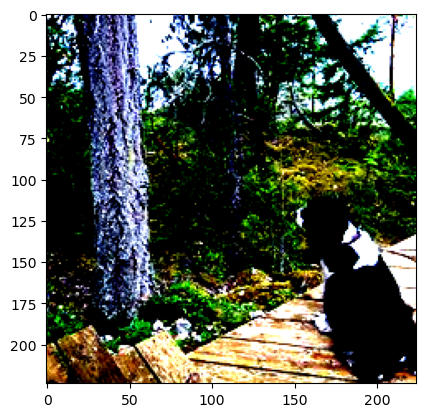

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [96] and output size of torch.Size([224, 224]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [22]:
%load_ext autoreload
%autoreload 2
from pytorch_grad_cam import GradCAM, LayerCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
from utils import _GradCAMPlusPlus, _LayerCAM, _ScoreCAM

input_tensor, label = test_data[1033]
input_tensor = input_tensor.unsqueeze(0).to(device)
print(input_tensor.shape)
output_tensor = model(input_tensor)
print(output_tensor.argmax())

plt.imshow(input_tensor[0].cpu().detach().numpy().transpose(1, 2, 0))
plt.show()

for i in range(len(model.layers)): 
    # cam = _GradCAMPlusPlus() 
    cam = _ScoreCAM() 

    # cam = _LayerCAM()
    # cam = GradCAM(model=model, target_layers=[model.layers[i].blocks[-1].norm2], reshape_transform=reshape_transform)
    # res = cam.attribute(input_tensor=input_tensor, target=[281], model=model, layer=model.norm, reshape_transform=reshape_transform)

    res = cam.attribute(input_tensor=input_tensor, target=[217], model=model, layer=model.layers[i].blocks[-1].norm2, reshape_transform=reshape_transform)

    print(res.min(), res.max())
    plt.imshow(res[0].cpu().detach().numpy()[0])
    plt.show()

In [8]:
(37632 / 7) / 84

64.0

In [9]:
model.norm

LayerNorm((768,), eps=1e-05, elementwise_affine=True)